In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import logging as log

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification, XLNetConfig
from transformers import *

from transformers import AdamW

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm, trange
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import multilabel_confusion_matrix, classification_report

SEED = 17

To update all modules run:

__pip install sentencepiece==0.1.95 pyarrow__

__pip3 list --outdated --format=freeze | grep -v '^\-e' | cut -d = -f 1  | xargs -n1 pip3 install -U__

Run that for an error saying *"ModuleNotFoundError: No module named 'transformers.modeling_xlnet'"*

In [2]:
log.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    filename='xlnet_dpcnn.log',
                    level=log.INFO)
logger = log.getLogger(__name__)

#### Setting up gpu environment

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

Preparing NYT dataset for *XLNet*


In [4]:
import pandas as pd
df_full = pd.read_parquet('../data/nyt.2000.parquet.gz')

In [5]:
df_full.shape

(32146, 14)

In [6]:
# sample a small set of observations for testing 
#df = df_full.sample(10000, random_state=SEED)

# full dataset for the real deal
df = df_full

df = df.set_index("Id")

In [7]:
df[df.Health == 1].head()

,Text,World,Washington,New_York_and_Region,Front_Page,Business,US,Sports,Obituaries,Health,Education,Science,Technology
Id,,,,,,,,,,,,,
1165059,The man accused of stabbing George Harrison on...,1,0,0,0,0,0,0,0,1,0,0,0
1165110,"Most nights, P. J. Sanchez, 9, comes into his ...",0,0,1,0,0,0,0,0,1,0,0,0
1165173,"Of all the instincts in animals, the strongest...",0,0,0,0,0,0,0,0,1,0,0,0
1165189,"THE Scarecrow in ""The Wizard of Oz"" wanted onl...",0,0,0,0,0,0,0,0,1,0,0,0
1165219,"UNLIKE the sheep named Dolly, the mouse named ...",0,0,0,0,0,0,0,0,1,0,0,0


In [8]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

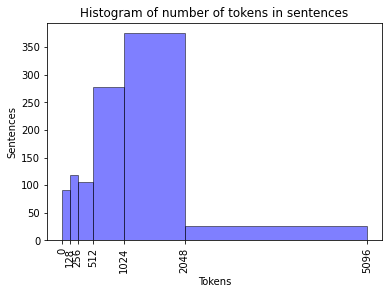

In [9]:
plt.hist(
    [len(s) for s in df.sample(1000)["Text"].apply(lambda x: tokenizer.tokenize(x))], 
    bins=[0, 128, 256, 512, 1024, 2048, 5096], 
    histtype='bar', 
    facecolor='b',
    edgecolor='k',
    alpha=0.5)
plt.xticks([0, 128, 256, 512, 1024, 2048, 5096], rotation='vertical')
plt.xlabel('Tokens')
plt.ylabel('Sentences')
plt.title('Histogram of number of tokens in sentences')
plt.show()

In [10]:
# Sentences larger than MAX_LEN are truncated (out-of-memory workaround)
MAX_LEN = 128

df_input_ids_full = df["Text"].copy()
XLNET_END_TOKEN_IDS = tokenizer.encode("[SEP][CLS]")

for i in tqdm(df_input_ids_full.index, desc="Tokenizer"):
  input_ids = tokenizer.convert_tokens_to_ids(
      tokenizer.tokenize(df_input_ids_full[i])[:MAX_LEN - len(XLNET_END_TOKEN_IDS)])
  df_input_ids_full.at[i] = input_ids + XLNET_END_TOKEN_IDS

df_input_ids_full.shape
# the code below causes out-of-memory crash and the code above was used

# convert to XLNet vocabulary tokens
#df["tokens"] = df["Text"].apply(lambda x: tokenizer.tokenize(x + " [SEP] [CLS]"))

# convert tokens to XLNet vocabulary ids
#df["input_ids_full"] = df["tokens"].apply(lambda x: tokenizer.convert_tokens_to_ids(x))

Tokenizer: 100%|██████████| 32146/32146 [01:07<00:00, 475.42it/s]


(32146,)

In [11]:
# using Keras function to handle padding
df["input_ids"] = pad_sequences(
    df_input_ids_full, 
    maxlen=MAX_LEN, 
    dtype="long", 
    padding="post", 
    value=0).tolist()

# Create XLNet masks: 1 for tokens 0 for padding
attention_masks = []
for input_id in df.input_ids:
  mask = [int(i>0) for i in input_id]
  attention_masks.append(mask)
df["attention_masks"] = attention_masks

# Create XLNet segments: 0 for each token of the first sentence, 
# followed by a 1 for each token of the second sentence.  For one sentence 
# inputs, this is simply a sequence of 0s
df["segment_masks"] = np.zeros((df.shape[0], MAX_LEN), dtype=int).tolist()

In [12]:
# check for a observation with less than MAX_LEN tokens
for i in df.index:
  if(np.count_nonzero(df.loc[i, "input_ids"]) < 128):
    print("Index:", i)
    print(df.loc[i, "Text"])
    print(df.loc[i, "input_ids"])
    print(np.count_nonzero(df.loc[i, "input_ids"]))
    print(df.loc[i, "attention_masks"])
    print(np.count_nonzero(df.loc[i, "attention_masks"]))
    print(df.loc[i, "segment_masks"])
    print(np.count_nonzero(df.loc[i, "segment_masks"]))
    break


Index: 1165119
The hijackers of an Indian Airlines plane won the release of three prominent militants jailed in India. All of them sped away from the airport in Afghanistan, trying to get out of the country. The names and nationalities of the hijackers are still unknown. With the release, more than 150 haggard passengers, kept on board for eight days, were freed unharmed. They flew to New Delhi, for family reunions, both wrenching and joyous.
[32, 24362, 20, 48, 1280, 6227, 2352, 282, 18, 947, 20, 139, 3788, 3211, 11733, 25, 837, 9, 394, 20, 107, 24646, 308, 40, 18, 2212, 25, 1805, 19, 619, 22, 133, 78, 20, 18, 234, 9, 32, 1931, 21, 27321, 20, 18, 24362, 41, 194, 4027, 9, 473, 18, 947, 19, 70, 100, 4076, 10118, 299, 11992, 3372, 19, 1340, 31, 1036, 28, 869, 307, 19, 55, 8494, 28510, 9, 200, 5415, 22, 158, 6849, 19, 28, 273, 15459, 23, 19, 207, 17, 29741, 21, 30584, 9, 4145, 83, 8186, 3158, 10849, 7416, 83, 3158, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [13]:
df.sample(5)

,Text,World,Washington,New_York_and_Region,Front_Page,Business,US,Sports,Obituaries,Health,Education,Science,Technology,input_ids,attention_masks,segment_masks
Id,,,,,,,,,,,,,,,,
1221402,CAN'T YOU HEAR ME CALLIN' The Life of Bill Mo...,0,0,0,0,0,1,0,0,0,0,0,0,"[7868, 26, 658, 13938, 732, 15026, 17, 5241, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1220990,"For the second time in two years, Darryl Straw...",0,0,0,0,0,0,1,0,1,0,0,0,"[247, 18, 205, 92, 25, 87, 123, 19, 28242, 290...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1169482,A recent study of women on active duty in the ...,0,0,0,0,0,0,0,0,1,0,0,0,"[79, 644, 757, 20, 412, 31, 1768, 3684, 25, 18...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1198566,"""Just put the violin on the shoulder, voomp!""\...",0,0,1,0,0,0,0,0,0,0,0,0,"[17, 12, 5817, 331, 18, 17680, 31, 18, 2741, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1195487,IN Paris recently the signs of spring were eve...,0,0,1,0,0,0,0,0,0,0,0,0,"[7039, 1737, 1050, 18, 2832, 20, 1919, 55, 593...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
import os

MODEL_PATH = "../xlnet"

In [15]:
xlnet_ds_prepared = MODEL_PATH + "/xlnet_prepared_ds_parquet.gzip"

df.to_parquet(xlnet_ds_prepared, compression='gzip')
df = pd.read_parquet(xlnet_ds_prepared)
#df = df.sample(50000, random_state = SEED)

#### Split training and test sets

In [16]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state = SEED)

print(train_df.shape, test_df.shape)

(25716, 16) (6430, 16)


#### Put data into data loader

In [17]:
tt_train_input_ids = torch.tensor(train_df["input_ids"].tolist())
tt_test_input_ids = torch.tensor(test_df["input_ids"].tolist())

tt_train_attention_masks = torch.tensor(train_df["attention_masks"].tolist())
tt_test_attention_masks = torch.tensor(test_df["attention_masks"].tolist())

tt_train_segment_masks = torch.tensor(train_df["segment_masks"].tolist())
tt_test_segment_masks = torch.tensor(test_df["segment_masks"].tolist())

label_columns = [
  'World',
  'Washington',
  'New_York_and_Region',
  'Front_Page',
  'Business',
  'US',
  'Sports',
  'Obituaries',
  'Health',
  'Education',
  'Science',
  'Technology']

tt_train_labels = torch.tensor(train_df[label_columns].values.astype(np.float))
tt_test_labels = torch.tensor(test_df[label_columns].values.astype(np.float))

In [18]:
# training batch size
batch_num = 32

train_data = TensorDataset(
    tt_train_input_ids, 
    tt_train_attention_masks, 
    tt_train_segment_masks, 
    tt_train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(
    train_data, sampler=train_sampler, batch_size=batch_num,drop_last=True)

valid_data = TensorDataset(
    tt_test_input_ids, 
    tt_test_attention_masks, 
    tt_test_segment_masks, 
    tt_test_labels)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(
    valid_data, sampler=valid_sampler, batch_size=batch_num)

#### DPCNN

In [19]:
class DPCNN(torch.nn.Module):
    def __init__(self, num_labels, channel_size=250, width=768):
        super(DPCNN, self).__init__()
        self.conv_embedding = torch.nn.Conv2d(1, channel_size, (3, width))
        self.conv2 = torch.nn.Conv2d(channel_size, channel_size, (3, 1))
        self.pooling = torch.nn.MaxPool2d(kernel_size=(3,1), stride=2)
        self.padding_conv = torch.nn.ZeroPad2d((0, 0, 1, 1))
        self.padding_pool = torch.nn.ZeroPad2d((0, 0, 0, 1))
        self.activation_function = torch.nn.ReLU()
        self.last_linear = torch.nn.Linear(channel_size, num_labels)
        self.channel_size = channel_size

    def forward(self, embeddings):
        
        batch_size, width, height = embeddings.shape

        # First transform the BERT embeddings (batch_size, num_characters, 768),
        # like (64, 80, 768)
        # to a 4D tensor like [64, 1, 80, 768] (required by the Conv2d)
        x = embeddings.view((batch_size, 1, width, height))

        # Run the first convolution (embedding). The output is [64, 250, 78, 1] 
        x = self.conv_embedding(x)
        #print(f'1 {x.shape}')        
        #x = self.activation_function(x)
        x_save = x

        # Run the second convolution. The output is [64, 250, 76, 1]
        x = self.conv2(x)
        #print(f'2 {x.shape}')

        # Add padding at starting and ending rows of the tensor. After that the
        # shape will be [64, 250, 78, 1]
        x = self.padding_conv(x)
        #x = self.activation_function(x)

        # Run another convolution. After that the shape will be [64, 250, 76, 1]
        x = self.conv2(x)
        x = self.padding_conv(x)
        x = x + self.activation_function(x_save)
        #print(f'3 {x.shape}')

        # Go over the blocks
        while x.shape[-2] >= 2:
            #print(x.shape)
            x = self.padding_pool(x)
            #print(f'3.1 {x.shape}')

            # Save the pool output to add that to the convolutions at the end
            pooling_x = self.pooling(x) 
            #print(f'pooling {pooling_x.shape}')

            # Perform the first convolution
            x = self.padding_conv(pooling_x)
            x = torch.nn.functional.relu(x)
            x = self.conv2(x)
            #print(f'4 {x.shape}')

            # Perform the second convolution
            x = self.padding_conv(x)
            x = F.relu(x)
            x = self.conv2(x)
            #print(f'5 {x.shape}')

            # Do the addition 
            x = x + pooling_x

        x = x.view(batch_size, self.channel_size)
        x = self.last_linear(x)
         
        return x

In [20]:
class XLNetDPCNN(XLNetPreTrainedModel):
    """XLNet model for multiple label classification."""
    def __init__(self, config):
        super(XLNetDPCNN, self).__init__(config)
        num_labels = len(label_columns)
        self.num_labels = num_labels
        self.xlnet = XLNetModel(config)
        self.dropout = torch.nn.Dropout(config.dropout)
        self.dpcnn = DPCNN(num_labels)
        self.classifier = torch.nn.Linear(num_labels, num_labels)

    def forward(self, 
                input_ids, 
                attention_mask=None, 
                mems=None, 
                perm_mask=None, 
                target_mapping=None,
                token_type_ids=None, 
                input_mask=None, 
                head_mask=None, 
                labels=None):
      
        transformer_outputs = self.xlnet(
            input_ids,
            attention_mask=attention_mask,
            mems=mems,
            perm_mask=perm_mask,
            target_mapping=target_mapping,
            token_type_ids=token_type_ids,
            input_mask=input_mask,
            head_mask=head_mask)

        output = transformer_outputs[0]
        x = self.dropout(output) 
        x = self.dpcnn(x)

        logits = self.classifier(x)

        outputs = (logits,) + transformer_outputs[1:]  # Keep mems, hidden states, attentions if there are in it

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = torch.nn.MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                #  We multilabel multiclass
                loss_fct = torch.nn.BCEWithLogitsLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
            outputs = (loss,) + outputs

        return outputs  # return (loss), logits, (mems), (hidden states), (attentions)



#### Custom Transformers

#### Load XLNet model

In [21]:
model = XLNetDPCNN.from_pretrained(
    'xlnet-base-cased', num_labels=len(label_columns))
model.cuda()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetDPCNN: ['transformer.mask_emb', 'transformer.word_embedding.weight', 'transformer.layer.0.rel_attn.q', 'transformer.layer.0.rel_attn.k', 'transformer.layer.0.rel_attn.v', 'transformer.layer.0.rel_attn.o', 'transformer.layer.0.rel_attn.r', 'transformer.layer.0.rel_attn.r_r_bias', 'transformer.layer.0.rel_attn.r_s_bias', 'transformer.layer.0.rel_attn.r_w_bias', 'transformer.layer.0.rel_attn.seg_embed', 'transformer.layer.0.rel_attn.layer_norm.weight', 'transformer.layer.0.rel_attn.layer_norm.bias', 'transformer.layer.0.ff.layer_norm.weight', 'transformer.layer.0.ff.layer_norm.bias', 'transformer.layer.0.ff.layer_1.weight', 'transformer.layer.0.ff.layer_1.bias', 'transformer.layer.0.ff.layer_2.weight', 'transformer.layer.0.ff.layer_2.bias', 'transformer.layer.1.rel_attn.q', 'transformer.layer.1.rel_attn.k', 'transformer.layer.1.rel_attn.v', 'transformer.layer.1.rel_attn.o', 'transformer.layer.1.r

XLNetDPCNN(
  (xlnet): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [22]:
# Set epoch and grad max num
epochs = 2
max_grad_norm = 1.0

In [23]:
# Fine tune model all layer parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
]
    
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)
optimizer

AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    lr: 3e-05
    weight_decay: 0.0
    weight_decay_rate: 0.01

Parameter Group 1
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    lr: 3e-05
    weight_decay: 0.0
    weight_decay_rate: 0.0
)

#### Fine-tuning the XLNet model

In [24]:
model.train()

XLNetDPCNN(
  (xlnet): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [25]:
print("***** Running training *****")
print("  Num examples = %d"%(len(tt_train_input_ids)))
print("  Batch size = %d"%(batch_num))
for _ in trange(epochs,desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_segs, b_labels = batch
        
        # forward pass
        outputs = model(
            input_ids = b_input_ids, 
            token_type_ids = b_segs, 
            input_mask = b_input_mask,
            labels= b_labels)
        loss, logits = outputs[:2]
        if n_gpu>1:
            # When multi gpu, average it
            loss = loss.mean()
        
        # backward pass
        loss.backward()
        
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        
        # update parameters
        optimizer.step()
        optimizer.zero_grad()
        
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 25716
  Batch size = 32


Epoch:  50%|█████     | 1/2 [24:39<24:39, 1479.40s/it]

Train loss: 0.2642765222673408


Epoch: 100%|██████████| 2/2 [49:31<00:00, 1485.88s/it]

Train loss: 0.1734589641481789


#### Saving the model

In [26]:
model_save_name = MODEL_PATH + "/pytorch_model.bin"
model_config_save_name = MODEL_PATH + "/config.json"
model_report_save_name = MODEL_PATH + "/eval_results.txt"

torch.save(model.state_dict(), model_save_name)
model.config.to_json_file(model_config_save_name)
tokenizer.save_vocabulary(MODEL_PATH)

('../xlnet/spiece.model',)

#### Loading finetuned model

In [27]:
model = XLNetDPCNN.from_pretrained(
    MODEL_PATH, num_labels=len(label_columns))
model.cuda()

XLNetDPCNN(
  (xlnet): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

#### Model evaluation

In [32]:
root_folder = '../xlnet'

def load_model(folder=MODEL_PATH):
    model = XLNetDPCNN.from_pretrained(MODEL_PATH, num_labels=len(label_columns))
    
    if n_gpu != 0:
        model.cuda()
      
    return model

def save_object(filename, obj, folder=root_folder):
    obj_file = os.path.join(folder, filename)

    if os.path.exists(obj_file):
        os.remove(obj_file)

    with open(obj_file, 'wb') as f:
        pickle.dump(obj, f)

def load_object(filename, folder=root_folder):
    object_file = os.path.join(folder, filename)

    with open(object_file, 'rb') as f:
        return pickle.load(f)

def calculate_confusion_matrix(data_loader, model, batch_size):
    model.eval()
    torch.cuda.empty_cache()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for step, batch in enumerate(data_loader):
            # add batch to gpu
            if n_gpu != 0:
                batch = tuple(t.to('cuda') for t in batch)
            
            logger.info(f'Step {step}')
            #import pdb; pdb.set_trace()
            b_input_ids, b_input_masks, b_segment_ids, b_labels = batch
        
            # forward pass
            #raw_outputs = model(b_input_ids, b_segment_ids, b_input_masks)
            raw_outputs = model(input_ids = b_input_ids, token_type_ids = b_segment_ids, input_mask = b_input_masks)
            predictions.append((torch.sigmoid(raw_outputs[0]) > .5).cpu().numpy().astype(int))
            true_labels.append(b_labels.cpu().numpy().astype(int))

        true_labels = np.vstack(true_labels)[0:(batch_size * len(predictions)),]
        predictions = np.vstack(predictions)

        return (multilabel_confusion_matrix(true_labels, predictions),
                true_labels,
                predictions)

def calculate_predictions(data_loader, model, batch_size):
    if n_gpu != 0:
        model.cuda()
        torch.cuda.empty_cache()

    model.eval()
    result = None

    with torch.no_grad():
        for step, batch in enumerate(data_loader):
            logger.info(f'Step {step}')
            
            # add batch to gpu
            if n_gpu != 0:
                batch = tuple(t.to('cuda') for t in batch)
                
            b_input_ids, b_input_masks, b_segment_ids, b_labels = batch
        
            # forward pass
            raw_outputs = model(b_input_ids, b_segment_ids, b_input_masks)
            predictions = torch.sigmoid(raw_outputs[2]).cpu()
            predictions = predictions.numpy()
            result = predictions if result is None else np.append(result, predictions, axis=0)
            
        return result

def get_label_columns(data_frame):
    skip_columns =  { 'Id', 'Text', 'input_ids', 'attention_masks', 'segment_masks' }
    return [c for c in data_frame.columns if c not in skip_columns and '_Pred' not in c]

def add_predictions(data_frame, features, model, batch_size):
    logits = calculate_predictions(features, model, batch_size)
    predictions = (logits > .5).astype(int)
    
    for i, column_name in enumerate(get_label_columns(data_frame)):
        data_frame[f'{column_name}_Pred'] = predictions[:, i]

def add_predictions_to_dataframe(data_frame, predictions):
    for i, column_name in enumerate(get_label_columns(data_frame)):
        data_frame[f'{column_name}_Pred'] = predictions[:, i]
        
class ModelResult:
    def __init__(self, data_frame, features, model, batch_size):
        confusion_matrix, labels, predictions = calculate_confusion_matrix(features, model, batch_size)
        self.confusion_matrix = confusion_matrix
        self.labels = labels
        self.predictions = predictions
        self.label_columns = get_label_columns(data_frame)
        
    def save(self, filename):
        save_object(filename, self)
        
    def get_classification_report(self, output_dictionary):
        return classification_report(self.labels, self.predictions, 
                                     target_names=self.label_columns, 
                                     output_dict=output_dictionary)
        
    def get_results_dataframe(self):
        report_dict = self.get_classification_report(True)
        label_columns = list(self.label_columns)
        label_columns.append('weighted avg')
        classification_results = pd.DataFrame({'Label':label_columns})
        classification_results['Precision'] = [report_dict[c]['precision'] for c in label_columns]
        classification_results['Recall'] = [report_dict[c]['recall'] for c in label_columns]
        classification_results['F1-Score'] = [report_dict[c]['f1-score'] for c in label_columns]
        classification_results['Support'] = [report_dict[c]['support'] for c in label_columns]
        classification_results.loc[classification_results['Label'] == 'weighted avg', 'Label'] = 'Weighted Average'
        
        return classification_results

In [33]:
model = load_model()

In [34]:
model_results = ModelResult(test_df, valid_dataloader, model, 100)

In [35]:
model_results.save('xlnet_dpcnn_result_test.pkl')

In [36]:
model_results = load_object('xlnet_dpcnn_result_test.pkl')
model_results.label_columns = get_label_columns(test_df)

In [37]:
add_predictions_to_dataframe(test_df, model_results.predictions)

<ipython-input-32-febcba5a553d>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame[f'{column_name}_Pred'] = predictions[:, i]


<AxesSubplot:ylabel='Frequency'>

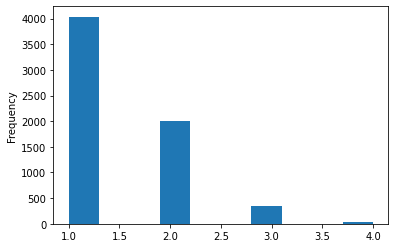

In [38]:
test_df[get_label_columns(test_df)].sum(1).plot.hist()

In [39]:
model_results.get_results_dataframe()

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Label,Precision,Recall,F1-Score,Support
0,World,0.760479,0.573363,0.653797,886
1,Washington,0.866883,0.359838,0.508571,742
2,New_York_and_Region,0.859075,0.660646,0.746906,1827
3,Front_Page,0.818182,0.188811,0.306818,286
4,Business,0.886792,0.766007,0.821986,859
5,US,0.736527,0.625954,0.676754,1965
6,Sports,0.916480,0.965171,0.940196,1694
7,Obituaries,0.973978,0.966790,0.970370,271
8,Health,1.000000,0.006623,0.013158,302
9,Education,0.000000,0.000000,0.000000,78


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:ylabel='Label'>

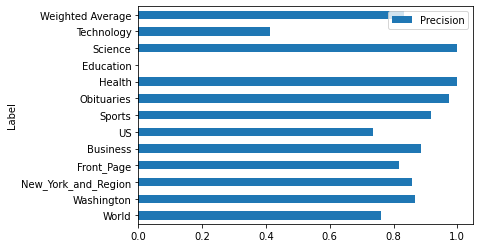

In [40]:
model_results.get_results_dataframe().plot.barh(x='Label', y='Precision')

#### Number of matches

<AxesSubplot:ylabel='Frequency'>

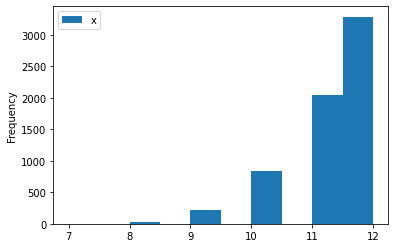

In [41]:
pd.DataFrame({'x':((model_results.labels == model_results.predictions).astype(int).sum(1))}).plot.hist()

In [42]:
model.eval();

In [43]:
# Softtmax accuracy
#def accuracy(out, labels):
#    outputs = np.argmax(out, axis=1)
#    return np.sum(outputs == labels)

# Multilabel accuracy
def accuracy(y_pred, y_true, thresh=0.5):
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    return np.mean(((y_pred > thresh) == y_true), axis=1).sum()

In [44]:
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

all_logits = None
all_labels = None

print("***** Running evaluation *****")
print("  Num examples ={}".format(len(tt_test_input_ids)))
print("  Batch size = {}".format(batch_num))

for step, batch in enumerate(valid_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_segs,b_labels = batch
    
    with torch.no_grad():
        outputs = model(
            input_ids = b_input_ids,
            token_type_ids = b_segs, 
            input_mask = b_input_mask,
            labels = b_labels)
        tmp_eval_loss, logits = outputs[:2]
    
    # Get textclassification predict result
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = accuracy(logits, label_ids)
    
    # Save predict and real label reuslt for analyze
    if all_logits is None:
        all_logits = logits
    else:
        all_logits = np.concatenate((all_logits, logits), axis=0)
        
    if all_labels is None:
        all_labels = label_ids
    else:    
        all_labels = np.concatenate((all_labels, label_ids), axis=0)

    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy
   
    nb_eval_steps += 1


    
eval_loss = eval_loss / nb_eval_steps
eval_accuracy = eval_accuracy / len(tt_test_input_ids)

#     ROC-AUC calcualation
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_columns)):
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), all_logits.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

result = {'eval_loss': eval_loss,
          'eval_accuracy': eval_accuracy,
          'roc_auc': roc_auc}

with open(model_report_save_name, "w") as writer:
    logger.info("***** Eval results *****")
    for key in sorted(result.keys()):
        logger.info("  %s = %s", key, str(result[key]))
        writer.write("%s = %s\n" % (key, str(result[key])))

***** Running evaluation *****
  Num examples =6430
  Batch size = 32


In [45]:
result

{'eval_loss': 0.16361501278451357,
 'eval_accuracy': 0.9390876101607047,
 'roc_auc': {0: 0.9109412815676923,
  1: 0.9318522041011293,
  2: 0.9323621193241456,
  3: 0.8127680425043706,
  4: 0.9635483437533761,
  5: 0.867810479585353,
  6: 0.9929611715833306,
  7: 0.9978185704896504,
  8: 0.8426287759583628,
  9: 0.7533565039075115,
  10: 0.8666364419685795,
  11: 0.8583924426138518,
  'micro': 0.9458338774643821}}